In [1]:
import sys
import os
import numpy as np
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
sys.path.append('/root/capsule/code/beh_ephys_analysis')
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.widgets as sw
from utils.hdf5_extractor import read_hdf5
from utils.beh_functions import session_dirs, parseSessionID
import h5py 
import matplotlib.pyplot as plt
%matplotlib widget
# %matplotlib inline

In [2]:
session = 'behavior_ZS061_2021-03-28_16-35-51'
session_dir = session_dirs(session)

Old data, using hopkins formats


In [14]:
rec_file = session_dir['raw_rec']
nwb_file = session_dir['nwb_dir_raw']
sorted_data_dir = session_dir['session_dir']
# 'session_dir': '/root/capsule/data/behavior_ZS061_2021-03-28_16-35-51_raw_data/ecephys/neuralynx/session'

In [4]:
rec = read_hdf5(rec_file)
print(rec)

(32, 95402336)
HDF5Recording: 32 channels - 32.0kHz - 1 segments - 95,402,336 samples - 2,981.32s (49.69 minutes) 
               int32 dtype - 11.37 GiB
  file_path: /root/capsule/data/behavior_ZS061_2021-03-28_16-35-51_raw_data/ecephys/neuralynx/session/raw_data.hdf5


In [5]:
start_time = rec.get_start_time()
end_time = rec.get_end_time()

In [6]:
rec.get_num_channels(), rec.get_num_samples()

(32, 95402336)

In [7]:
sample = rec.get_traces(start_frame=0, end_frame=10*rec.get_sampling_frequency())

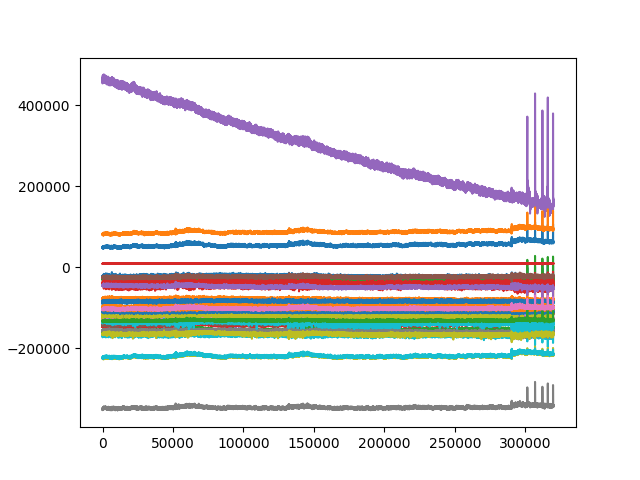

In [8]:
plt.plot(sample);

In [11]:
# # read hdf5 file
# file = r"D:\raw_ephys_conversion\ZS062\mZS062d20210405\neuralynx\session\raw_data.hdf5"

# with h5py.File(file, "r") as f:
#     dset = f["/samples"]
#     subset = dset[:, 32000*10:32000*11]   # first 10 rows, all columns
#     print(dset.dtype)

In [9]:
rec.get_channel_groups()

array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5,
       5, 5, 6, 6, 6, 6, 7, 7, 7, 7])

In [10]:
bad_channels= ['10']
# rec = rec.remove_channels(bad_channels)
recording_raw_fake = spre.bandpass_filter(rec, freq_min=50, freq_max=8000)
recording_raw_fake = spre.common_reference(recording_raw_fake)

In [11]:
sw.set_default_plotter_backend('ipywidgets')

In [12]:
sw.plot_traces(recording_raw_fake, color_groups = True)

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

In [16]:
sorting = se.read_nwb_sorting(
    nwb_file, sampling_frequency=rec.sampling_frequency, t_start=start_time
)
sorting = sorting.rename_units(sorting.get_property('unit_id'))
units = list(sorting.unit_ids)
unit_ids = sorting.unit_ids
# group = [int(unit_id[2])-1 for unit_id in units]
# sorting.set_property('group', group)
# sorting.get_property('group')

/opt/conda/lib/python3.10/site-packages/spikeinterface/extractors/nwbextractors.py:1304: UserWarning: Skipping wf_2d_opto because of unequal shapes across units
  warnings.warn(f"Skipping {property_name} because of unequal shapes across units")


In [17]:
# gather all spike times
all_spike_times = []
all_labels = []
for unit_id in unit_ids:
    file = os.path.join(sorted_data_dir, f"{unit_id}.txt")
    timestamps = list(np.loadtxt(file)/1000000)
    all_spike_times.extend(timestamps)
    all_labels.extend(list(np.full(len(timestamps), fill_value=unit_id)))


In [22]:
# convert to timestamps
rec_timestamps = rec.get_times()
all_spike_times = np.asarray(all_spike_times)

idx = np.searchsorted(rec_timestamps, all_spike_times)
idx[idx == len(rec_timestamps)] = len(rec_timestamps) - 1  # clip overflow
# Correct for the fact that closest could be on the left or right
left_idx = np.clip(idx - 1, 0, len(rec_timestamps)-1)
# Pick whichever neighbor is closer
choose_left = np.abs(all_spike_times - rec_timestamps[left_idx]) < np.abs(all_spike_times - rec_timestamps[idx])
frame_ind = np.where(choose_left, left_idx, idx)

In [23]:
import json
sparsity_params_file = '/root/capsule/code/beh_ephys_analysis/params.json'
with open(sparsity_params_file, 'r') as f:
    postprocessing_params = json.load(f)
job_kwargs = postprocessing_params.pop("job_kwargs")
job_kwargs["n_jobs"] = 8
si.set_global_job_kwargs(**job_kwargs)

sparsity_params = postprocessing_params.pop("sparsity")
quality_metrics_names = postprocessing_params.pop("quality_metrics_names")
quality_metrics_params = postprocessing_params.pop("quality_metrics")

analyzer_dict = postprocessing_params.copy()
analyzer_dict.pop("duplicate_threshold")
analyzer_dict.pop("return_scaled")

True

In [24]:
sorting = si.NumpySorting.from_samples_and_labels(
    samples_list= np.array(frame_ind),
    labels_list= np.array(all_labels),
    sampling_frequency=rec.sampling_frequency,
)
units = list(sorting.unit_ids)
group = [int(unit_id[2])-1 for unit_id in units]
sorting.set_property('group', group)
sorting.get_property('group')
# sorting_saved = sorting.save(folder=os.path.join(sorted_data_dir,"highres_timestamps_sorting"), overwrite=True)
# # sorting_loaded = si.load("..")

array([0, 0, 2, 2, 2, 3, 4])

In [25]:
sorting.get_property('group')

array([0, 0, 2, 2, 2, 3, 4])

In [26]:
si.set_global_job_kwargs(n_jobs=0.7, mp_context='spawn', progress_bar=True)

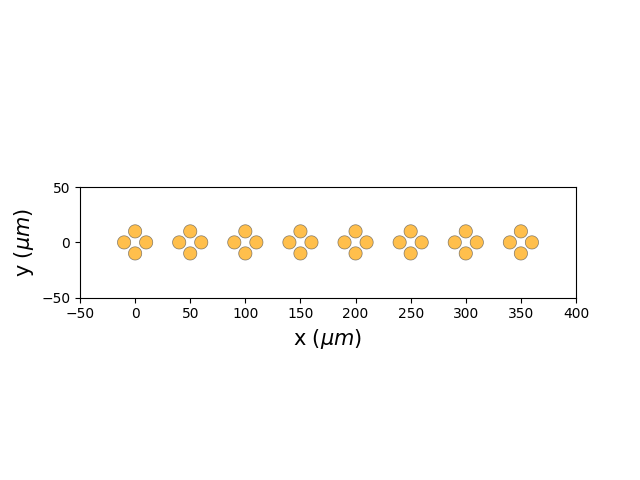

In [27]:
sw.plot_probe_map(recording_raw_fake, backend="matplotlib")

In [28]:
analyzer = si.create_sorting_analyzer(
    sorting=sorting,
    recording=recording_raw_fake,
    # radius_um=30,
    method="by_property",
    by_property="group",
    # sparsity=False
)

In [29]:
_ = analyzer.compute(analyzer_dict)

/opt/conda/lib/python3.10/site-packages/spikeinterface/core/recording_tools.py:780: UserWarning: get_noise_levels(recording, num_chunks_per_segment=20) is deprecated
Now, you need to use get_noise_levels(recording, random_slices_kwargs=dict(num_chunks_per_segment=20, chunk_size=1000))
Please read get_random_recording_slices() documentation for more options.
  warnings.warn(msg)


noise_level (workers: 11 processes):   0%|          | 0/20 [00:00<?, ?it/s]

(32, 95402336)
(32, 95402336)(32, 95402336)(32, 95402336)(32, 95402336)(32, 95402336)(32, 95402336)





(32, 95402336)(32, 95402336)

(32, 95402336)(32, 95402336)

(32, 95402336)
(32, 95402336)
(32, 95402336)
(32, 95402336)
(32, 95402336)
(32, 95402336)
(32, 95402336)
(32, 95402336)
(32, 95402336)
(32, 95402336)
(32, 95402336)


compute_waveforms (workers: 11 processes):   0%|          | 0/2982 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/spikeinterface/postprocessing/template_metrics.py:303: UserWarning: With less than 10 channels, multi-channel metrics might not be reliable.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/spikeinterface/postprocessing/template_metrics.py:303: UserWarning: With less than 10 channels, multi-channel metrics might not be reliable.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/spikeinterface/postprocessing/template_metrics.py:303: UserWarning: With less than 10 channels, multi-channel metrics might not be reliable.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/spikeinterface/postprocessing/template_metrics.py:303: UserWarning: With less than 10 channels, multi-channel metrics might not be reliable.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/spikeinterface/postprocessing/template_metrics.py:303: UserWarning: With less than 10 channels, multi-channel metrics might not be reliable.
  warnings.warn(
/opt/conda

Fitting PCA:   0%|          | 0/7 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/7 [00:00<?, ?it/s]

(32, 95402336)
(32, 95402336)
(32, 95402336)
(32, 95402336)
(32, 95402336)
(32, 95402336)
(32, 95402336)
(32, 95402336)
(32, 95402336)
(32, 95402336)
(32, 95402336)
(32, 95402336)
(32, 95402336)
(32, 95402336)
(32, 95402336)
(32, 95402336)
(32, 95402336)
(32, 95402336)
(32, 95402336)
(32, 95402336)
(32, 95402336)
(32, 95402336)


Compute : spike_amplitudes + spike_locations (workers: 11 processes):   0%|          | 0/2982 [00:00<?, ?it/s]

In [35]:
_ = analyzer.compute(
    "quality_metrics",
    metric_names=quality_metrics_names,
    qm_params=quality_metrics_params
)
waveform_zarr_folder = f'{session_dir[f"ephys_dir_curated"]}/analyzer.zarr'
if os.path.exists(waveform_zarr_folder):
    print("Zarr folder already exists, deleting.")
    shutil.rmtree(waveform_zarr_folder)
analyzer_saved_zarr = analyzer.save_as(format='zarr', folder = waveform_zarr_folder)

calculate_pc_metrics:   0%|          | 0/7 [00:00<?, ?it/s]

In [36]:
# gather info for correction
analyzer_loaded = si.load(waveform_zarr_folder)


(32, 95402336)


In [37]:
analyzer.unit_ids

array(['TT1_SS_01', 'TT1_SS_03', 'TT3_SS_01', 'TT3_SS_02', 'TT3_SS_03',
       'TT4_SS_01', 'TT5_SS_01'], dtype='<U9')